<h1 align="center">Coder Mê Tài Chính</h1>

---
<table width="100%" style="border:0px solid black;">
    <tr style="font-size: 16pt">
        <td><strong>Evangelist</strong>: Lê Minh Đạt</td>
        <td><b>Email</b>: <a href="mailto:sirminhdat@gmail.com">sirminhdat@gmail.com</a></td>
        <td><b>Zalo</b>: 0919 564 515</td>
    </tr>
</table>


<h1 align="center" style="color: #ffef96"><b>Xây dựng mô hình ước tính tổn thất dự kiến (Expected Loss Model)<br> bằng Machine Learning (ML)</b></h1>

## <span style="color: #79E0EE">Mục tiêu cần đạt được:</span>
- Sử dụng ML để xây dựng mô hình dự đoán xác suất vỡ nợ (Default) của các khoản vay trong danh mục.
- Khi đã dự tính được xác xuất vỡ nợ, áp dụng mô hình tổn thất dự kiến để tính tổn thất của danh mục.

## <span style="color: #79E0EE">Công thức tính tổn thất dự kiến (EL):</span>

$$
  EL = PD \times LGD \times Loan\_Amount
$$

- PD: Probability of Default – xác suất khách hàng không trả được nợ; &rarr; giá trị này phải predict
- LGD: Loss Given Default – tỉ trọng tổn thất ước tính; 
- Loan_Amount: tổng dư nợ của khách hàng tại thời điểm khách hàng không trả được nợ; 
- Trong đó, LGD được tính:
$$
    LGD = \frac{(Loan\_Amount - Số\_tiền\_có\_thể\_thu\_hồi)}{Loan\_Amount}
$$

- Trong bài này, dữ liệu mà ta sử dụng không có feature nào thể hiện giá trị "Số tiền có thể thu hồi" &rarr; cho LGD = 1

Tham khảo: https://vietnambiz.vn/mo-hinh-uoc-tinh-ton-that-du-kien-expected-loss-model-la-gi-20190830122300429.htm

## <span style="color: #79E0EE">Nguồn dữ liệu gốc:</span>
File CSV (Dung lượng khoản 1,77GB. Khi download về sẽ là file zip, sau khi unzip thì đổi đuôi file Loan_status_2007-2020Q3.gzip thành Loan_status_2007-2020Q3.csv):

-- https://www.kaggle.com/code/faressayah/lending-club-loan-defaulters-prediction/input?select=Loan_status_2007-2020Q3.gzip

File mô tả các features:

-- https://www.kaggle.com/code/faressayah/lending-club-loan-defaulters-prediction/input?select=LCDataDictionary.xlsx

### <span style="color: #79E0EE">Dữ liệu sử dụng trong bài:</span>
- Mình đã chọn ra 15 cột (feature) phù hợp, có liên quan đến bài trong số 151 cột từ file gốc để tạo lại file dữ liệu với định dạng file là .parquet để nén cho dung lượng nhỏ lại (khoản 29MB). Số lượng quan sát mình vẫn lấy tất cả là khoản 2,9 triệu dòng.

In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re

%matplotlib inline
# plt.style.use('ggplot')
sns.set_style('darkgrid')

In [17]:
data_file = "data/loan/loan_status_essential_15cols.parquet"
ori_df = pd.read_parquet(data_file)
ori_df.head()

,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,issue_d,loan_status,purpose,dti,earliest_cr_line,application_type,chargeoff_within_12_mths,pub_rec_bankruptcies
0,5000.0,36 months,10.65%,B,10+ years,RENT,24000.0,Dec-2011,Fully Paid,credit_card,27.65,Jan-1985,Individual,0.0,0.0
1,2500.0,60 months,15.27%,C,< 1 year,RENT,30000.0,Dec-2011,Charged Off,car,1.00,Apr-1999,Individual,0.0,0.0
2,2400.0,36 months,15.96%,C,10+ years,RENT,12252.0,Dec-2011,Fully Paid,small_business,8.72,Nov-2001,Individual,0.0,0.0
3,10000.0,36 months,13.49%,C,10+ years,RENT,49200.0,Dec-2011,Fully Paid,other,20.00,Feb-1996,Individual,0.0,0.0
4,3000.0,60 months,12.69%,B,1 year,RENT,80000.0,Dec-2011,Fully Paid,other,17.94,Jan-1996,Individual,0.0,0.0


In [18]:
ori_df.shape

(2925493, 15)

## <span style="color: #79E0EE">Mô tả các cột dữ liệu</span>

<table border="0" style="font-size: 18px">
  <thead>
    <tr style="text-align: left;">
      <th>#</th>
      <th>Tên cột</th>
      <th>Diễn giải</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1</th>
      <td>loan_amnt</td>
      <td>Số dư nợ của người vay.</td>
    </tr>
    <tr>
      <th>2</th>
      <td>term</td>
      <td>Kỳ hạn vay.</td>
    </tr>
    <tr>
      <th>3</th>
      <td>int_rate</td>
      <td>Lãi suất của khoản vay</td>
    </tr>    
    <tr>
      <th>4</th>
      <td>grade</td>
      <td>Xếp hạng tín dụng của khoản vay</td>
    </tr>      
    <tr>
      <th>5</th>
      <td>emp_length</td>
      <td>Thời gian làm việc của người vay tính bằng năm trong khoản [0; 10]. 0: dưới 1 năm; 10: trên 10 năm.</td>
    </tr>
    <tr>
      <th>6</th>
      <td>home_ownership</td>
      <td>Tình trạng sở hữu nhà: RENT, OWN, MORTGAGE, OTHER</td>
    </tr>
    <tr>
      <th>7</th>
      <td>annual_inc</td>
      <td>Thu nhập hàng năm của người vay.</td>
    </tr>    
    <tr>
      <th>8</th>
      <td>issue_d</td>
      <td>Tháng mà khoản vay được giải ngân</td>
    </tr>
    <tr>
      <th>9</th>
      <td>loan_status</td>
      <td>Trạng thái hiện tại của khoản vay</td>
    </tr>
    <tr>
      <th>10</th>
      <td>purpose</td>
      <td>Mục đích vay.</td>
    </tr>       
    <tr>
      <th>11</th>
      <td>dti</td>
      <td>Debt to Income: Tỉ lệ khoản phải trả hàng tháng bao gồm tiền gốc và lãi trên thu nhập của người vay.</td>
    </tr>
    <tr>
      <th>12</th>
      <td>earliest_cr_line</td>
      <td>The month the borrower's earliest reported credit line was opened</td>
    </tr>    
    <tr>
      <th>13</th>
      <td>application_type</td>
      <td>Một cá nhân vay hay là đồng chung 2 người vay</td>
    </tr>   
    <tr>
      <th>14</th>
      <td>pub_rec_bankruptcies</td>
      <td>Số vụ phá sản được ghi nhận công khai</td>
    </tr>      
    <tr>
      <th>15</th>
      <td>chargeoff_within_12_mths</td>
      <td>Số lần charge-off trong vòng 12 tháng</td>
    </tr>
  </tbody>
</table>

In [19]:
use_cols = [
    'loan_amnt', # Số dư nợ của người vay
    'term', # Kỳ hạn vay
    'int_rate', # Lãi suất của khoản vay
    'grade', # Xếp hạng tín dụng của khoản vay
    'emp_length', # Thời gian làm việc của người vay tính bằng năm trong khoản [0; 10]. 0: dưới 1 năm; 10: từ 10 năm trở lên
    'home_ownership', # Tình trạng sở hữu nhà: RENT, OWN, MORTGAGE, OTHER
    'annual_inc', # Thu nhập hàng năm của người vay
    'issue_d', # Tháng mà khoản vay được giải ngân
    'loan_status', # Trạng thái hiện tại của khoản vay
    'purpose', # Mục đích vay
    'dti', # Debt to Income: Tỉ lệ khoản phải trả hàng tháng bao gồm tiền gốc và lãi trên thu nhập của người vay
    'earliest_cr_line', # The month the borrower's earliest reported credit line was opened
    'application_type', # Một cá nhân vay hay là đồng chung 2 người vay
    'pub_rec_bankruptcies', # Số vụ phá sản được ghi nhận công khai
    'chargeoff_within_12_mths' # Số lần charge-off trong vòng 12 tháng
]

essential_df = ori_df.copy()

## <span style="color: #79E0EE">Loại bỏ các dòng dữ liệu có giá trị Null</span>

In [20]:
essential_df.isna().sum()

loan_amnt                        1
term                             1
int_rate                         1
grade                            1
emp_length                  205221
home_ownership                   1
annual_inc                       5
issue_d                          1
loan_status                      1
purpose                          1
dti                           3109
earliest_cr_line                30
application_type                 1
chargeoff_within_12_mths       146
pub_rec_bankruptcies          1366
dtype: int64

In [21]:
essential_df.dropna(inplace=True)
essential_df.isna().sum()

loan_amnt                   0
term                        0
int_rate                    0
grade                       0
emp_length                  0
home_ownership              0
annual_inc                  0
issue_d                     0
loan_status                 0
purpose                     0
dti                         0
earliest_cr_line            0
application_type            0
chargeoff_within_12_mths    0
pub_rec_bankruptcies        0
dtype: int64

## <span style="color: #79E0EE">Set kiểu dữ liệu tương ứng là loại Numeric, Datetime hoặc Categorical</span>

In [74]:
essential_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2718623 entries, 0 to 2925492
Data columns (total 15 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   loan_amnt                 float64
 1   term                      object 
 2   int_rate                  object 
 3   grade                     object 
 4   emp_length                object 
 5   home_ownership            object 
 6   annual_inc                float64
 7   issue_d                   object 
 8   loan_status               object 
 9   purpose                   object 
 10  dti                       float64
 11  earliest_cr_line          object 
 12  application_type          object 
 13  chargeoff_within_12_mths  float64
 14  pub_rec_bankruptcies      float64
dtypes: float64(5), object(10)
memory usage: 331.9+ MB


In [22]:
# Set index lại sau khi đã loại bỏ các dòng có giá trị null
essential_df.reset_index(drop=True, inplace=True)

In [23]:
dt_cols = ['issue_d', 'earliest_cr_line']

#Convert datetime
essential_df[dt_cols] = essential_df[dt_cols].apply(pd.to_datetime)

In [24]:
essential_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2718623 entries, 0 to 2718622
Data columns (total 15 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   loan_amnt                 float64       
 1   term                      object        
 2   int_rate                  object        
 3   grade                     object        
 4   emp_length                object        
 5   home_ownership            object        
 6   annual_inc                float64       
 7   issue_d                   datetime64[ns]
 8   loan_status               object        
 9   purpose                   object        
 10  dti                       float64       
 11  earliest_cr_line          datetime64[ns]
 12  application_type          object        
 13  chargeoff_within_12_mths  float64       
 14  pub_rec_bankruptcies      float64       
dtypes: datetime64[ns](2), float64(5), object(8)
memory usage: 311.1+ MB


In [25]:
categorical_cols = ['term', 'grade', 'home_ownership', 'purpose', 'application_type', 'loan_status']
for col in categorical_cols:
    essential_df[col] = essential_df[col].str.strip()
    essential_df[col] = essential_df[col].astype('category')

In [27]:
def convert_int_rate(x):
    s = re.compile(r"^\s*(\d*\.?\d*)").search(x).group(1)
    return float(s)

# convert_int_rate(' 123.65%')
# essential_df['int_rate'] = essential_df['int_rate'].str.strip('%')
# essential_df['int_rate'] = essential_df['int_rate'].apply(pd.to_numeric)
essential_df['int_rate'] = essential_df['int_rate'].apply(convert_int_rate)

In [28]:
essential_df

,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,issue_d,loan_status,purpose,dti,earliest_cr_line,application_type,chargeoff_within_12_mths,pub_rec_bankruptcies
0,5000.0,36 months,10.65,B,10+ years,RENT,24000.0,2011-12-01,Fully Paid,credit_card,27.65,1985-01-01,Individual,0.0,0.0
1,2500.0,60 months,15.27,C,< 1 year,RENT,30000.0,2011-12-01,Charged Off,car,1.00,1999-04-01,Individual,0.0,0.0
2,2400.0,36 months,15.96,C,10+ years,RENT,12252.0,2011-12-01,Fully Paid,small_business,8.72,2001-11-01,Individual,0.0,0.0
3,10000.0,36 months,13.49,C,10+ years,RENT,49200.0,2011-12-01,Fully Paid,other,20.00,1996-02-01,Individual,0.0,0.0
4,3000.0,60 months,12.69,B,1 year,RENT,80000.0,2011-12-01,Fully Paid,other,17.94,1996-01-01,Individual,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2718618,24000.0,60 months,23.99,E,< 1 year,RENT,107000.0,2017-04-01,Charged Off,other,11.65,1995-04-01,Individual,1.0,1.0
2718619,10000.0,36 months,7.99,A,10+ years,MORTGAGE,65000.0,2017-04-01,Fully Paid,debt_consolidation,19.55,1993-09-01,Individual,0.0,0.0
2718620,10050.0,36 months,16.99,D,8 years,RENT,37000.0,2017-04-01,Charged Off,debt_consolidation,20.56,1993-05-01,Individual,0.0,0.0
2718621,6000.0,36 months,11.44,B,5 years,RENT,41000.0,2017-04-01,Fully Paid,credit_card,19.99,1990-05-01,Individual,0.0,0.0


In [29]:
essential_df['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years'],
      dtype=object)

In [30]:
def extract_emp_length_num(x):
    s = re.compile(r"(.+)year").search(x).group(1).strip()
    if s == '10+':
        return 10
    
    if s == '< 1':
        return 0
    
    return int(s)

# extract_emp_length_num('7 years')
essential_df['emp_length'] = essential_df['emp_length'].apply(extract_emp_length_num)

In [31]:
essential_df

,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,issue_d,loan_status,purpose,dti,earliest_cr_line,application_type,chargeoff_within_12_mths,pub_rec_bankruptcies
0,5000.0,36 months,10.65,B,10,RENT,24000.0,2011-12-01,Fully Paid,credit_card,27.65,1985-01-01,Individual,0.0,0.0
1,2500.0,60 months,15.27,C,0,RENT,30000.0,2011-12-01,Charged Off,car,1.00,1999-04-01,Individual,0.0,0.0
2,2400.0,36 months,15.96,C,10,RENT,12252.0,2011-12-01,Fully Paid,small_business,8.72,2001-11-01,Individual,0.0,0.0
3,10000.0,36 months,13.49,C,10,RENT,49200.0,2011-12-01,Fully Paid,other,20.00,1996-02-01,Individual,0.0,0.0
4,3000.0,60 months,12.69,B,1,RENT,80000.0,2011-12-01,Fully Paid,other,17.94,1996-01-01,Individual,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2718618,24000.0,60 months,23.99,E,0,RENT,107000.0,2017-04-01,Charged Off,other,11.65,1995-04-01,Individual,1.0,1.0
2718619,10000.0,36 months,7.99,A,10,MORTGAGE,65000.0,2017-04-01,Fully Paid,debt_consolidation,19.55,1993-09-01,Individual,0.0,0.0
2718620,10050.0,36 months,16.99,D,8,RENT,37000.0,2017-04-01,Charged Off,debt_consolidation,20.56,1993-05-01,Individual,0.0,0.0
2718621,6000.0,36 months,11.44,B,5,RENT,41000.0,2017-04-01,Fully Paid,credit_card,19.99,1990-05-01,Individual,0.0,0.0


In [32]:
essential_df['loan_status'].value_counts()

Fully Paid                                             1410670
Current                                                 946110
Charged Off                                             331691
Late (31-120 days)                                       14302
In Grace Period                                           9197
Late (16-30 days)                                         2337
Issued                                                    1903
Does not meet the credit policy. Status:Fully Paid        1514
Does not meet the credit policy. Status:Charged Off        530
Default                                                    369
Name: loan_status, dtype: int64

In [33]:
# 0: Non-Default
# 1: Default
replace_pattern = {
    'Fully Paid': 0, 
    'Current': 0, 
    'Charged Off': 1,
    'Late (31-120 days)': 1, 
    'In Grace Period': 1,
    'Late (16-30 days)': 1,
    'Issued': 0,
    'Does not meet the credit policy. Status:Fully Paid': 0,
    'Does not meet the credit policy. Status:Charged Off': 1,
    'Default': 1
}
essential_df['loan_status'] = essential_df['loan_status'].replace(replace_pattern)

In [34]:
essential_df

,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,issue_d,loan_status,purpose,dti,earliest_cr_line,application_type,chargeoff_within_12_mths,pub_rec_bankruptcies
0,5000.0,36 months,10.65,B,10,RENT,24000.0,2011-12-01,0,credit_card,27.65,1985-01-01,Individual,0.0,0.0
1,2500.0,60 months,15.27,C,0,RENT,30000.0,2011-12-01,1,car,1.00,1999-04-01,Individual,0.0,0.0
2,2400.0,36 months,15.96,C,10,RENT,12252.0,2011-12-01,0,small_business,8.72,2001-11-01,Individual,0.0,0.0
3,10000.0,36 months,13.49,C,10,RENT,49200.0,2011-12-01,0,other,20.00,1996-02-01,Individual,0.0,0.0
4,3000.0,60 months,12.69,B,1,RENT,80000.0,2011-12-01,0,other,17.94,1996-01-01,Individual,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2718618,24000.0,60 months,23.99,E,0,RENT,107000.0,2017-04-01,1,other,11.65,1995-04-01,Individual,1.0,1.0
2718619,10000.0,36 months,7.99,A,10,MORTGAGE,65000.0,2017-04-01,0,debt_consolidation,19.55,1993-09-01,Individual,0.0,0.0
2718620,10050.0,36 months,16.99,D,8,RENT,37000.0,2017-04-01,1,debt_consolidation,20.56,1993-05-01,Individual,0.0,0.0
2718621,6000.0,36 months,11.44,B,5,RENT,41000.0,2017-04-01,0,credit_card,19.99,1990-05-01,Individual,0.0,0.0


## <span style="color: #79E0EE">EDA</span>

In [35]:
essential_df['loan_status'].value_counts()

0    2360197
1     358426
Name: loan_status, dtype: int64

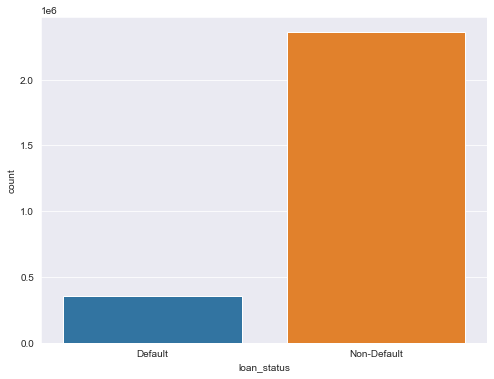

In [38]:
fig = plt.figure(figsize=(8, 6))
ax = sns.countplot(data=essential_df, x='loan_status')
ax.set_xticklabels(labels=['Default', 'Non-Default'])
plt.show()

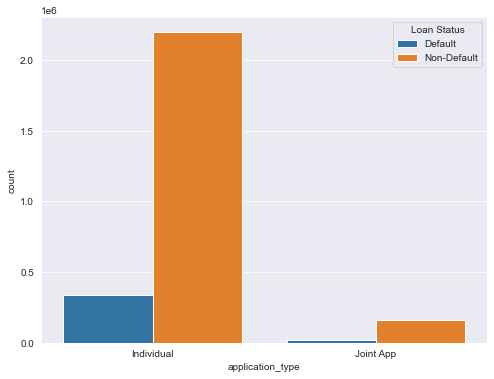

In [39]:
fig = plt.figure(figsize=(8, 6))
ax = sns.countplot(data=essential_df, x='application_type', hue='loan_status')
ax.legend(labels=['Default', 'Non-Default'], title="Loan Status")
plt.show()

In [40]:
essential_df['home_ownership'].unique()

['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE', 'ANY']
Categories (6, object): ['ANY', 'MORTGAGE', 'NONE', 'OTHER', 'OWN', 'RENT']

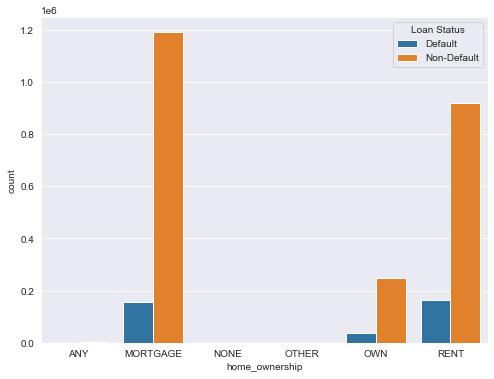

In [41]:
fig = plt.figure(figsize=(8, 6))
ax = sns.countplot(data=essential_df, x='home_ownership', hue='loan_status')
ax.legend(labels=['Default', 'Non-Default'], title="Loan Status")
plt.show()

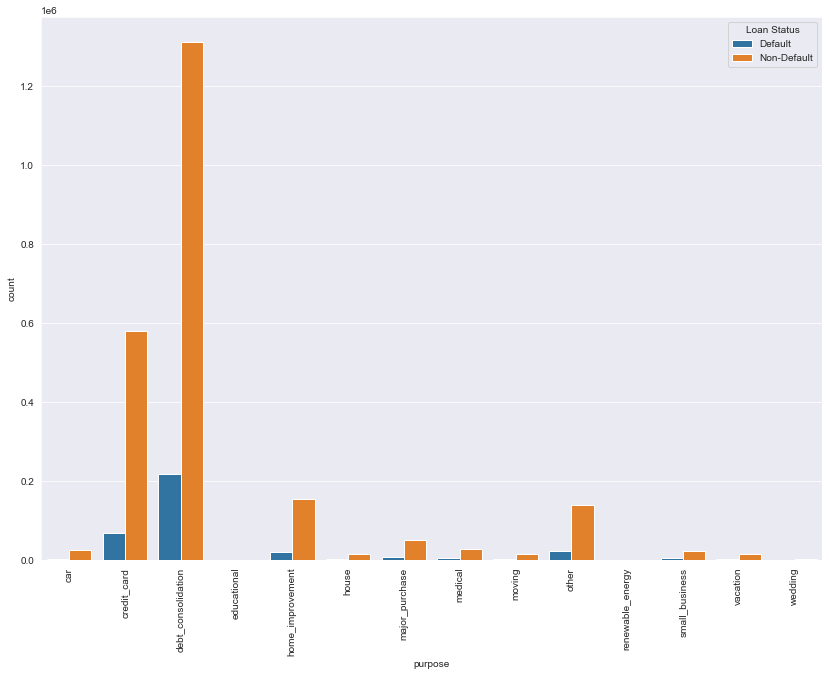

In [42]:
fig = plt.figure(figsize=(14, 10))
ax = sns.countplot(data=essential_df, x='purpose', hue='loan_status')
ax.legend(labels=['Default', 'Non-Default'], title="Loan Status")
plt.xticks(rotation=90)
plt.show()

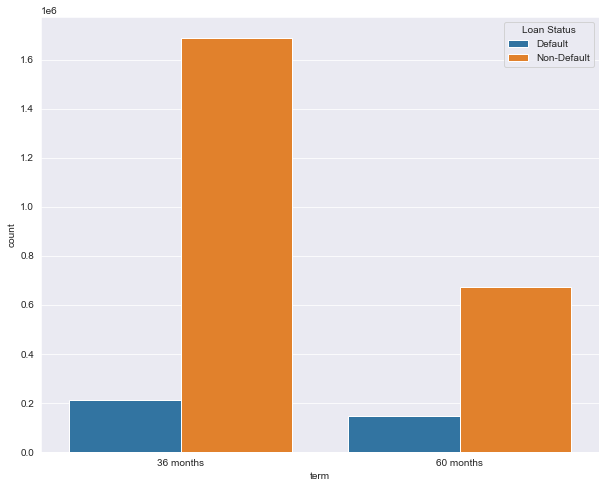

In [43]:
fig = plt.figure(figsize=(10, 8))
ax = sns.countplot(data=essential_df, x='term', hue='loan_status')
ax.legend(labels=['Default', 'Non-Default'], title="Loan Status")
plt.show()

In [83]:
# Xem tứ phân vị (quantile)
essential_df['dti'].describe()

count    2.718623e+06
mean     1.901565e+01
std      1.303746e+01
min     -1.000000e+00
25%      1.205000e+01
50%      1.800000e+01
75%      2.470000e+01
max      9.990000e+02
Name: dti, dtype: float64

In [85]:
pd.qcut(x=essential_df['dti'], q=4)

0            (24.7, 999.0]
1          (-1.001, 12.05]
2          (-1.001, 12.05]
3             (18.0, 24.7]
4            (12.05, 18.0]
                ...       
2718618    (-1.001, 12.05]
2718619       (18.0, 24.7]
2718620       (18.0, 24.7]
2718621       (18.0, 24.7]
2718622      (24.7, 999.0]
Name: dti, Length: 2718623, dtype: category
Categories (4, interval[float64, right]): [(-1.001, 12.05] < (12.05, 18.0] < (18.0, 24.7] < (24.7, 999.0]]

In [101]:
dti_cat = ['0-12', '12-18', '18-24', 'over 24']
dti_quantile_data = pd.qcut(x=essential_df['dti'], q=4, labels=dti_cat)
dti_quantile_data

0          over 24
1             0-12
2             0-12
3            18-24
4            12-18
            ...   
2718618       0-12
2718619      18-24
2718620      18-24
2718621      18-24
2718622    over 24
Name: dti, Length: 2718623, dtype: category
Categories (4, object): ['0-12' < '12-18' < '18-24' < 'over 24']

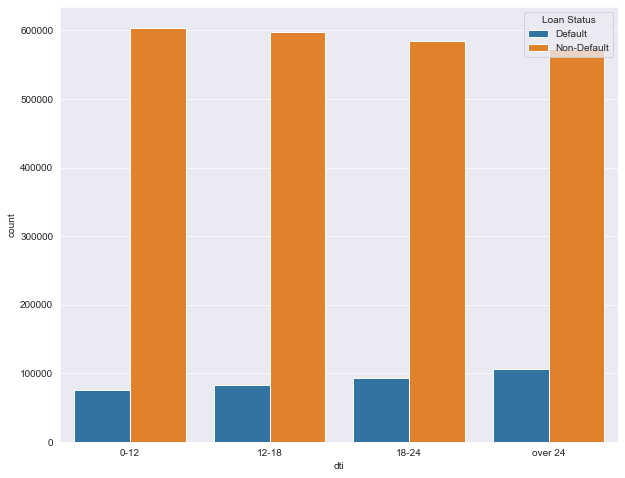

In [87]:
fig = plt.figure(figsize=(10, 8))
ax = sns.countplot(x=dti_quantile_data, hue=essential_df['loan_status'])
ax.legend(labels=['Default', 'Non-Default'], title="Loan Status")
plt.show()

In [44]:
essential_df['annual_inc'].describe()

count    2.718623e+06
mean     8.212958e+04
std      1.133429e+05
min      0.000000e+00
25%      4.991600e+04
50%      6.938900e+04
75%      9.800000e+04
max      1.100000e+08
Name: annual_inc, dtype: float64

In [45]:
annual_cat = ['Low', 'Average', 'High', 'Luxury']
anu_quantile_data = pd.qcut(x=essential_df['annual_inc'], q=4, labels=annual_cat)
anu_quantile_data

0              Low
1              Low
2              Low
3              Low
4             High
            ...   
2718618     Luxury
2718619    Average
2718620        Low
2718621        Low
2718622     Luxury
Name: annual_inc, Length: 2718623, dtype: category
Categories (4, object): ['Low' < 'Average' < 'High' < 'Luxury']

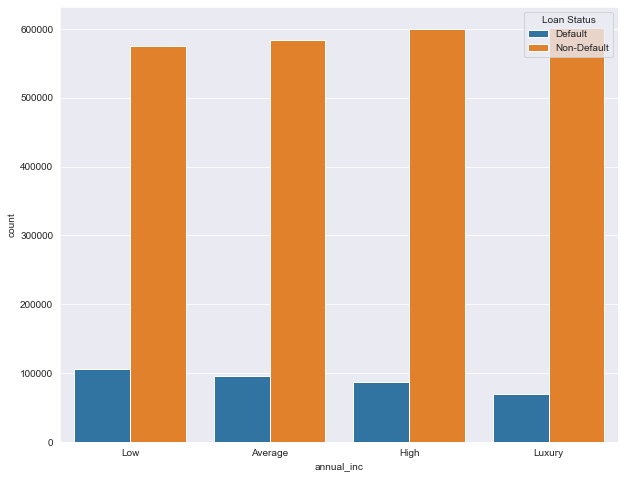

In [46]:
fig = plt.figure(figsize=(10, 8))
ax = sns.countplot(x=anu_quantile_data, hue=essential_df['loan_status'])
ax.legend(labels=['Default', 'Non-Default'], title="Loan Status")
plt.show()

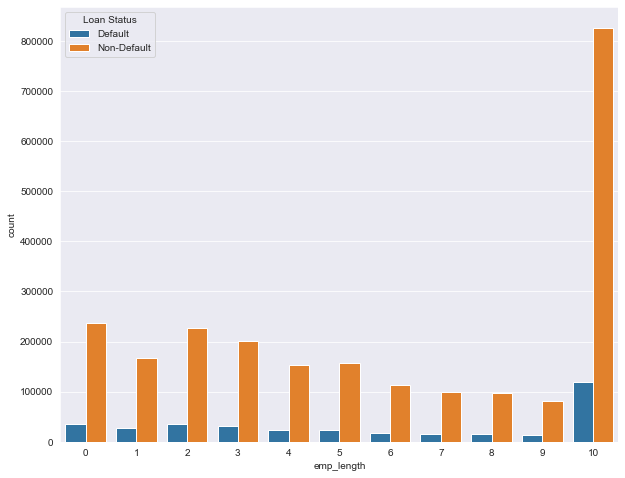

In [80]:
fig = plt.figure(figsize=(10, 8))
ax = sns.countplot(data=essential_df, x='emp_length', hue=essential_df['loan_status'])
ax.legend(labels=['Default', 'Non-Default'], title="Loan Status")
plt.show()

## <span style="color: #79E0EE">Prepare data</span>

In [47]:
process_df = essential_df.drop(labels=['grade'], axis=1)

In [48]:
# Tính số tháng giữa issue_d và earliest_cr_line
process_df['months_cr_history'] = np.round((process_df['issue_d'] - process_df['earliest_cr_line'])/np.timedelta64(1, 'M'))
process_df['months_cr_history'] = process_df['months_cr_history'].astype(int)

In [49]:
process_df['months_cr_history']

0          323
1          152
2          121
3          190
4          191
          ... 
2718618    264
2718619    283
2718620    287
2718621    323
2718622    233
Name: months_cr_history, Length: 2718623, dtype: int32

In [50]:
process_df['application_type'] = process_df['application_type'].replace('Joint App', 'Joint_App')

In [51]:
process_df['application_type'].unique()

['Individual', 'Joint_App']
Categories (2, object): ['Individual', 'Joint_App']

In [52]:
process_df['term'] = process_df['term'].apply(lambda x: x.replace(' ', '_'))

In [53]:
process_df['term'].unique()

['36_months', '60_months']
Categories (2, object): ['36_months', '60_months']

In [55]:
process_df['term'].unique()

['36_months', '60_months']
Categories (2, object): ['36_months', '60_months']

In [56]:
# Tạo biến dummies của từng biến categorical: term, home_ownership, purpose, application_type
term_dummy = pd.get_dummies(process_df['term'], prefix="term")
term_dummy

,term_36_months,term_60_months
0,1,0
1,0,1
2,1,0
3,1,0
4,0,1
...,...,...
2718618,0,1
2718619,1,0
2718620,1,0
2718621,1,0


In [57]:
dum_prefix = {
    'term': 'term',
    'home_ownership': 'home_ownership',
    'purpose': 'purpose',
    'application_type': 'app_type'
}

# pandas tự động remove các cột categorical sau khi tạo các cột dummies
processed_df = pd.get_dummies(process_df, columns=list(dum_prefix.keys()), prefix=list(dum_prefix.values()))

In [58]:
processed_df.columns

Index(['loan_amnt', 'int_rate', 'emp_length', 'annual_inc', 'issue_d',
       'loan_status', 'dti', 'earliest_cr_line', 'chargeoff_within_12_mths',
       'pub_rec_bankruptcies', 'months_cr_history', 'term_36_months',
       'term_60_months', 'home_ownership_ANY', 'home_ownership_MORTGAGE',
       'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'purpose_car', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'app_type_Individual',
       'app_type_Joint_App'],
      dtype='object')

In [25]:
processed_df.to_parquet("tmp/loan_status_processed_df.parquet")

In [26]:
del process_df, essential_df

In [ ]:
# Just in case the memory is run out when trained model. We don't need to preprosess data again. Just reload it at here
processed_df = pd.read_parquet("tmp/loan_status_processed_df.parquet")
processed_df

## <span style="color: #79E0EE">Training Model by Machine Learning</span>

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score

In [54]:
X_features = processed_df.drop(['loan_status', 'issue_d', 'earliest_cr_line'], axis=1)
y_target = processed_df['loan_status']

In [55]:
X_features

,loan_amnt,int_rate,emp_length,annual_inc,dti,chargeoff_within_12_mths,pub_rec_bankruptcies,months_cr_history,term_36_months,term_60_months,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,app_type_Individual,app_type_Joint_App
0,5000.0,10.65,10,24000.0,27.65,0.0,0.0,323,1,0,...,0,0,0,0,0,0,0,0,1,0
1,2500.0,15.27,0,30000.0,1.00,0.0,0.0,152,0,1,...,0,0,0,0,0,0,0,0,1,0
2,2400.0,15.96,10,12252.0,8.72,0.0,0.0,121,1,0,...,0,0,0,0,0,1,0,0,1,0
3,10000.0,13.49,10,49200.0,20.00,0.0,0.0,190,1,0,...,0,0,0,1,0,0,0,0,1,0
4,3000.0,12.69,1,80000.0,17.94,0.0,0.0,191,0,1,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2718618,24000.0,23.99,0,107000.0,11.65,1.0,1.0,264,0,1,...,0,0,0,1,0,0,0,0,1,0
2718619,10000.0,7.99,10,65000.0,19.55,0.0,0.0,283,1,0,...,0,0,0,0,0,0,0,0,1,0
2718620,10050.0,16.99,8,37000.0,20.56,0.0,0.0,287,1,0,...,0,0,0,0,0,0,0,0,1,0
2718621,6000.0,11.44,5,41000.0,19.99,0.0,0.0,323,1,0,...,0,0,0,0,0,0,0,0,1,0


In [56]:
y_target

0          0
1          1
2          0
3          0
4          0
          ..
2718618    1
2718619    0
2718620    1
2718621    0
2718622    1
Name: loan_status, Length: 2718623, dtype: int64

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=2412)

In [32]:
del X_features, y_target, processed_df

In [33]:
y_train.value_counts()

0    1651604
1     251432
Name: loan_status, dtype: int64

### <span style="color: #79E0EE">Imbalance Data</span>
- Mất cân bằng dữ liệu là một trong những hiện tượng phổ biến của bài toán phân loại nhị phân (binary classification) như spam email, phát hiện gian lận, dự báo vỡ nợ, chuẩn đoán bệnh lý,…. Trong trường hợp tỷ lệ dữ liệu giữa 2 classes là 50:50 thì được coi là cân bằng. Khi có sự khác biệt trong phân phối giữa 2 classes, chẳng hạn 60:40 thì dữ liệu có hiện tượng mất cân bằng.

- Hầu hết các bộ dữ liệu đều khó đạt được trạng thái cân bằng mà luôn có sự khác biệt về tỷ lệ giữa 2 classes

#### Undersampling
- Undersampling là việc ta giảm số lượng các quan sát của nhóm đa số (majority) để nó trở nên cân bằng với số quan sát của nhóm thiểu số. Ưu điểm của under sampling là làm cân bằng mẫu một cách nhanh chóng, dễ dàng tiến hành thực hiện mà không cần đến thuật toán giả lập mẫu.

- Tuy nhiên nhược điểm của nó là kích thước mẫu sẽ bị giảm đáng kể

#### Oversampling
Oversampling là các phương pháp giúp giải quyết hiện tượng mất cân bằng mẫu bằng cách gia tăng kích thước mẫu thuộc nhóm thiểu số (minority)

Tham khảo: https://phamdinhkhanh.github.io/2020/02/17/ImbalancedData.html

### <span style="color: #79E0EE">Oversampling</span>

In [34]:
from imblearn.over_sampling import SMOTE

# minority: thiểu số
smote = SMOTE(sampling_strategy="minority", random_state=81)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [35]:
del X_train, y_train

In [67]:
y_train_resampled.value_counts()

1    1651604
0    1651604
Name: loan_status, dtype: int64

### <span style="color: #79E0EE">Logistic Regression</span>

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
lr_model = LogisticRegression()
lr_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression()

In [44]:
lr_y_preds = lr_model.predict(X_test)
lr_y_preds

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [45]:
lr_y_proba_preds = lr_model.predict_proba(X_test)
lr_y_proba_preds # [0;1] hoặc ['Non-Default'; 'Default']

array([[0.2520305 , 0.7479695 ],
       [0.53938634, 0.46061366],
       [0.59622802, 0.40377198],
       ...,
       [0.57644955, 0.42355045],
       [0.6463713 , 0.3536287 ],
       [0.59676406, 0.40323594]])

In [46]:
# Dòng: lấy tất cả; Cột: lấy cột có index = 1 (Lấy dữ liệu là toàn bộ giá trị ở cột 1)
lr_y_proba_preds[:,1]

array([0.7479695 , 0.46061366, 0.40377198, ..., 0.42355045, 0.3536287 ,
       0.40323594])

In [65]:
results_df = pd.concat([
        pd.DataFrame(y_test.reset_index(drop=True)),
        pd.DataFrame(lr_y_preds, columns=['lr_pred']),
        pd.DataFrame(lr_y_proba_preds[:,1], columns=['lr_pred_proba'])
    ], axis=1)

results_df

,loan_status,lr_pred,lr_pred_proba
0,0,1,0.747969
1,1,0,0.460614
2,1,0,0.403772
3,0,1,0.556681
4,0,0,0.332546
...,...,...,...
815582,0,1,0.577449
815583,0,1,0.502695
815584,0,0,0.423550
815585,0,0,0.353629


In [35]:
results_df.to_parquet("tmp/data_result.parquet")

In [37]:
del lr_model

### <span style="color: #79E0EE">Random Forest Classifier</span>

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [39]:
# rfc_model = RandomForestClassifier(
#     n_estimators=150,
#     max_depth=80,
#     min_samples_split=15,
#     min_samples_leaf=5,
#     bootstrap=True,
#     random_state=1000
# )
rfc_model = RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=1000)
rfc_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=1000)

In [40]:
rfc_y_preds = rfc_model.predict(X_test)
rfc_y_preds

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [41]:
rfc_y_proba_preds = rfc_model.predict_proba(X_test)
rfc_y_proba_preds

array([[0.52, 0.48],
       [0.46, 0.54],
       [0.98, 0.02],
       ...,
       [0.93, 0.07],
       [0.94, 0.06],
       [0.94, 0.06]])

In [ ]:
# Đọc data của bảng results đã lưu lên lại
results_df = pd.read_parquet("tmp/data_result.parquet")
results_df

In [42]:
# Ghép các cột mới vào dataframe results
results_df = pd.concat([
        results_df,
        pd.DataFrame(rfc_y_preds, columns=['rfc_pred']),
        pd.DataFrame(rfc_y_proba_preds[:,1], columns=['rfc_pred_proba'])
    ], axis=1)

results_df

,loan_status,lr_pred,lr_pred_proba,rfc_pred,rfc_pred_proba
0,0,1,0.747969,0,0.48
1,1,0,0.460614,1,0.54
2,1,0,0.403772,0,0.02
3,0,1,0.556681,0,0.18
4,0,0,0.332546,0,0.15
...,...,...,...,...,...
815582,0,1,0.577449,0,0.37
815583,0,1,0.502695,0,0.04
815584,0,0,0.423550,0,0.07
815585,0,0,0.353629,0,0.06


In [43]:
# Lưu dataframe vừa mới ghép các cột mới ra file lại
results_df.to_parquet("tmp/data_result.parquet")

In [44]:
del rfc_model

### <span style="color: #79E0EE">XGBoost - eXtreme Gradient Boosting</span>

In [30]:
import xgboost as xgb

In [31]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [32]:
xgb_y_preds = xgb_model.predict(X_test)
xgb_y_preds

array([0, 1, 0, ..., 0, 0, 0])

In [33]:
xgb_y_proba_preds = xgb_model.predict_proba(X_test)
xgb_y_proba_preds

array([[0.5545094 , 0.44549063],
       [0.4238053 , 0.5761947 ],
       [0.9696807 , 0.03031929],
       ...,
       [0.8910381 , 0.1089619 ],
       [0.93928075, 0.06071925],
       [0.91982234, 0.08017764]], dtype=float32)

In [34]:
# Đọc file data results
results_df = pd.read_parquet("tmp/data_result.parquet")
results_df

,loan_status,lr_pred,lr_pred_proba,rfc_pred,rfc_pred_proba
0,0,1,0.747969,0,0.48
1,1,0,0.460614,1,0.54
2,1,0,0.403772,0,0.02
3,0,1,0.556681,0,0.18
4,0,0,0.332546,0,0.15
...,...,...,...,...,...
815582,0,1,0.577449,0,0.37
815583,0,1,0.502695,0,0.04
815584,0,0,0.423550,0,0.07
815585,0,0,0.353629,0,0.06


In [35]:
# Ghép cột kết quả của xgb vào dataframe results
results_df = pd.concat([
        results_df,
        pd.DataFrame(xgb_y_preds, columns=['xgb_pred']),
        pd.DataFrame(xgb_y_proba_preds[:,1], columns=['xgb_pred_proba'])
    ], axis=1)
results_df

,loan_status,lr_pred,lr_pred_proba,rfc_pred,rfc_pred_proba,xgb_pred,xgb_pred_proba
0,0,1,0.747969,0,0.48,0,0.445491
1,1,0,0.460614,1,0.54,1,0.576195
2,1,0,0.403772,0,0.02,0,0.030319
3,0,1,0.556681,0,0.18,0,0.176089
4,0,0,0.332546,0,0.15,0,0.102333
...,...,...,...,...,...,...,...
815582,0,1,0.577449,0,0.37,0,0.232104
815583,0,1,0.502695,0,0.04,0,0.080450
815584,0,0,0.423550,0,0.07,0,0.108962
815585,0,0,0.353629,0,0.06,0,0.060719


In [36]:
# Cuối cùng, lưu lại
results_df.to_parquet("tmp/data_result.parquet")

## <span style="color: #79E0EE">Đánh giá các model</span>

In [59]:
# Đọc lên lại dataframe results
results_df = pd.read_parquet("tmp/data_result.parquet")
results_df

,loan_status,lr_pred,lr_pred_proba,rfc_pred,rfc_pred_proba,xgb_pred,xgb_pred_proba
0,0,1,0.747969,0,0.48,0,0.445491
1,1,0,0.460614,1,0.54,1,0.576195
2,1,0,0.403772,0,0.02,0,0.030319
3,0,1,0.556681,0,0.18,0,0.176089
4,0,0,0.332546,0,0.15,0,0.102333
...,...,...,...,...,...,...,...
815582,0,1,0.577449,0,0.37,0,0.232104
815583,0,1,0.502695,0,0.04,0,0.080450
815584,0,0,0.423550,0,0.07,0,0.108962
815585,0,0,0.353629,0,0.06,0,0.060719


### <span style="color: #79E0EE">Confusion Matrix</span>

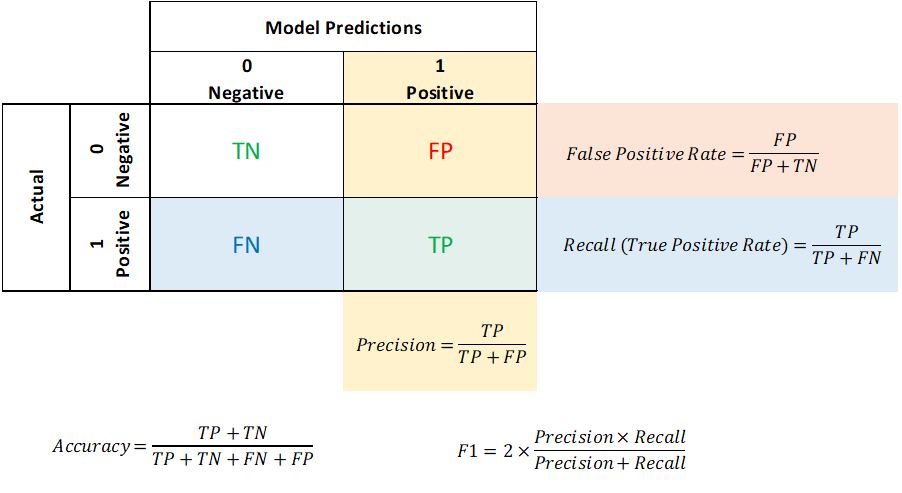

- Chỉ số Accuracy chỉ dùng để đánh giá khi dữ liệu không bị bất đối xứng. Accuracy càng cao càng tốt.
- Ngược lại, khi dữ liệu có tình trạng bất đối xứng thì dùng các chỉ số: Precision, Recall và F1 để đánh giá

---
- Precision: là tỉ lệ(%) số trường hợp Positive mô hình dự đoán đúng trên tổng số trường hợp mô hình dự đoán là Positive.
- Recall: là tỉ lệ(%) số trường hợp Positive mô hình dự đoán đúng trên tổng số trường hợp thật sự là Positive.
- F1 score: Là số dung hòa (Harmonic mean) giữa Recall và Precision giúp ta có căn cứ để lựa chọn model. F1 càng cao càng tốt.
---
Tham khảo: https://caihuuthuc.wordpress.com/2020/02/23/precision-recall-va-f1-score-la-gi/

In [66]:
print(confusion_matrix(results_df['loan_status'], results_df['lr_pred']))

[[397193 311400]
 [ 35819  71175]]


In [67]:
print(classification_report(results_df['loan_status'], results_df['lr_pred'], target_names=['Non-Default', 'Default']))

              precision    recall  f1-score   support

 Non-Default       0.92      0.56      0.70    708593
     Default       0.19      0.67      0.29    106994

    accuracy                           0.57    815587
   macro avg       0.55      0.61      0.49    815587
weighted avg       0.82      0.57      0.64    815587



#### <span style="color: #79E0EE">Define my custom classification report function</span>

In [64]:
def my_classification_report(y_test, y_proba_preds, labels={0:'Non-Default', 1:'Default'}, threshold=0.5):
    
    y_preds = np.where(y_proba_preds >= threshold, 1, 0)
    
    report_df = pd.DataFrame()
    for i in labels:
        precision = precision_score(y_test, y_preds, pos_label=i)
        recall = recall_score(y_test, y_preds, pos_label=i)
        f1 = f1_score(y_test, y_preds, pos_label=i)
        
        tmp_df = pd.DataFrame([f"{precision:.2f}", f"{recall:.2f}", f"{f1:.2f}"], columns=[labels[i]])
        report_df = pd.concat([report_df, tmp_df], axis=1)
    
    report_df = report_df.rename(index={0:'Precision', 1:'Recall', 2:'F1_score'})
    
    accuracy = accuracy_score(y_test, y_preds)
    
    cfm = confusion_matrix(y_test, y_preds)
    cfm_labled = pd.DataFrame(
            cfm,
            index=['Actual : Negative (0)','Actual : Positive (1)'],
            columns=['Predict : Negative (0)','Predict :Positive (1)']
    )
    
    # print("-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
    print(report_df)
    print('---------')
    print(f"Accuracy = {accuracy:.2f}")
    # print("-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
    
    return cfm_labled

In [65]:
my_classification_report(results_df['loan_status'], results_df['lr_pred_proba']) # default threshold=0.5

          Non-Default Default
Precision        0.92    0.19
Recall           0.56    0.67
F1_score         0.70    0.29
---------
Accuracy = 0.57


,Predict : Negative (0),Predict :Positive (1)
Actual : Negative (0),397193,311400
Actual : Positive (1),35819,71175


In [69]:
my_classification_report(results_df['loan_status'], results_df['lr_pred_proba'], threshold=0.7)

          Non-Default Default
Precision        0.88    0.28
Recall           0.95    0.14
F1_score         0.91    0.18
---------
Accuracy = 0.84


,Predict : Negative (0),Predict :Positive (1)
Actual : Negative (0),669681,38912
Actual : Positive (1),92128,14866


In [70]:
my_classification_report(results_df['loan_status'], results_df['rfc_pred_proba'])

          Non-Default Default
Precision        0.87    0.31
Recall           0.98    0.06
F1_score         0.92    0.10
---------
Accuracy = 0.86


,Predict : Negative (0),Predict :Positive (1)
Actual : Negative (0),695378,13215
Actual : Positive (1),100979,6015


In [71]:
my_classification_report(results_df['loan_status'], results_df['rfc_pred_proba'], threshold=0.7)

          Non-Default Default
Precision        0.87    0.34
Recall           1.00    0.00
F1_score         0.93    0.01
---------
Accuracy = 0.87


,Predict : Negative (0),Predict :Positive (1)
Actual : Negative (0),707841,752
Actual : Positive (1),106609,385


In [72]:
my_classification_report(results_df['loan_status'], results_df['xgb_pred_proba'])

          Non-Default Default
Precision        0.87    0.37
Recall           0.99    0.05
F1_score         0.93    0.09
---------
Accuracy = 0.86


,Predict : Negative (0),Predict :Positive (1)
Actual : Negative (0),699527,9066
Actual : Positive (1),101687,5307


In [73]:
my_classification_report(results_df['loan_status'], results_df['xgb_pred_proba'], threshold=0.7)

          Non-Default Default
Precision        0.87    0.50
Recall           1.00    0.00
F1_score         0.93    0.00
---------
Accuracy = 0.87


,Predict : Negative (0),Predict :Positive (1)
Actual : Negative (0),708499,94
Actual : Positive (1),106901,93


### <span style="color: #79E0EE">ROC - Receiver Operating Characteristic</span>

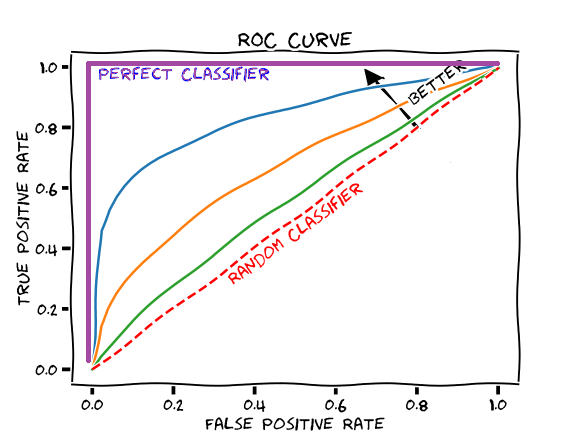

Tham khảo: https://sefiks.com/2020/12/10/a-gentle-introduction-to-roc-curve-and-auc/

#### <span style="color: #79E0EE">Define my custom plot ROC curve function</span>

In [69]:
def plot_roc_curve(y_test, data=None, col_names={}, colors={}):
    plt.figure(figsize=(12,10))
    
    # No skill prediction
    ns_proba = np.ones(len(y_test)) * 0.5
    ns_fpr, ns_sensitivity, ns_thresholds = roc_curve(y_test, ns_proba)
    ns_auc = roc_auc_score(y_test, ns_proba)
    plt.plot(ns_fpr, ns_sensitivity, linestyle='-.', color="steelblue", label="No Skill")
    # plt.plot([0, 1], [0, 1], linestyle='-.', label="No Skill")
    
    plt.text(0.9, 0.1, f"AUC = {ns_auc:.3f}", ha='right', fontsize=16, weight='bold', color='steelblue')
    plt.fill_between(ns_fpr, ns_sensitivity, facecolor='LightSteelBlue', alpha=0.6)
    
    
    # Model prediction
    y_auc = 0.2
    for col in col_names:
        y_proba = data[col]
        fpr, sensitivity, thresholds = roc_curve(y_test, y_proba)
        model_auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, sensitivity, color=colors[col], label=col_names[col])
        plt.text(0.9, y_auc, f"AUC = {model_auc:.3f}", ha='right', fontsize=16, weight='bold', color=colors[col])
        plt.fill_between(fpr, sensitivity, facecolor='#FFD580', alpha=0.4)
        y_auc += 0.1
            
    plt.title(f"ROC Chart")
    plt.xlabel("False Positive Rate")
    plt.ylabel("Sensitivity")
    plt.legend(fontsize=14)
    plt.show()

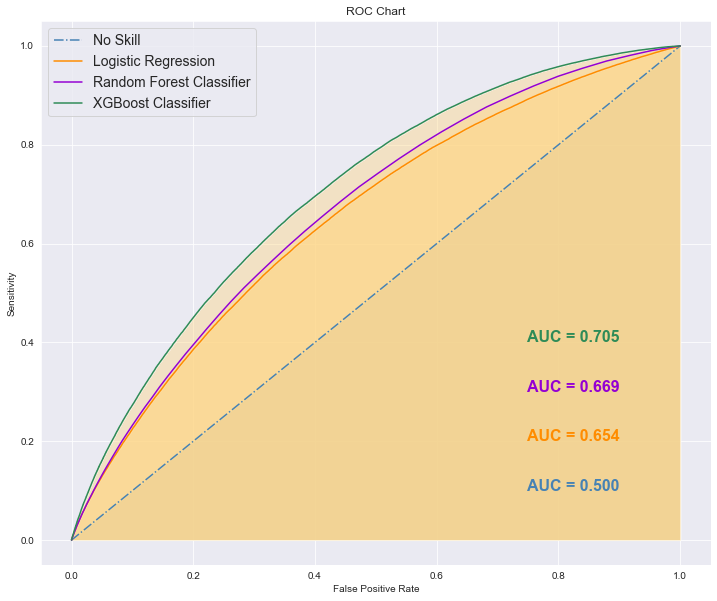

In [71]:
# AUC = Area Under the ROC Curve
dict_names = {
    'lr_pred_proba': 'Logistic Regression',
    'rfc_pred_proba': 'Random Forest Classifier',
    'xgb_pred_proba': 'XGBoost Classifier'
}
colors = {
    'lr_pred_proba': '#FF8C00',
    'rfc_pred_proba': '#9400D3',
    'xgb_pred_proba': '#2E8B57'
}

plot_roc_curve(results_df['loan_status'], data=results_df, col_names=dict_names, colors=colors)

## <span style="color: #79E0EE">Portfolio Expected Loss (trên tập dữ liệu Test)</span>

In [60]:
#Thêm cột loan_amnt và cột lgd
results_df['loan_amnt'] = X_test['loan_amnt'].copy().reset_index(drop=True)
results_df['lgd'] = 1
results_df

,loan_status,lr_pred,lr_pred_proba,rfc_pred,rfc_pred_proba,xgb_pred,xgb_pred_proba,loan_amnt,lgd
0,0,1,0.747969,0,0.48,0,0.445491,18000.0,1
1,1,0,0.460614,1,0.54,1,0.576195,7200.0,1
2,1,0,0.403772,0,0.02,0,0.030319,20000.0,1
3,0,1,0.556681,0,0.18,0,0.176089,30000.0,1
4,0,0,0.332546,0,0.15,0,0.102333,12025.0,1
...,...,...,...,...,...,...,...,...,...
815582,0,1,0.577449,0,0.37,0,0.232104,35000.0,1
815583,0,1,0.502695,0,0.04,0,0.080450,20000.0,1
815584,0,0,0.423550,0,0.07,0,0.108962,25000.0,1
815585,0,0,0.353629,0,0.06,0,0.060719,4000.0,1


$$
  EL = PD \times LGD \times Loan\_Amount
$$

In [88]:
# tính Expected Loss trên từng kết quả xác suất của từng model
results_df['lr_expected_lost'] = results_df['lr_pred_proba'] * results_df['lgd'] * results_df['loan_amnt']
results_df['rfc_expected_lost'] = results_df['rfc_pred_proba'] * results_df['lgd'] * results_df['loan_amnt']
results_df['xgb_expected_lost'] = results_df['xgb_pred_proba'] * results_df['lgd'] * results_df['loan_amnt']
results_df

,loan_status,lr_pred,lr_pred_proba,rfc_pred,rfc_pred_proba,xgb_pred,xgb_pred_proba,loan_amnt,lgd,lr_expected_lost,rfc_expected_lost,xgb_expected_lost
0,0,1,0.747969,0,0.48,0,0.445491,18000.0,1,13463.450976,8640.00,8018.831313
1,1,0,0.460614,1,0.54,1,0.576195,7200.0,1,3316.418386,3888.00,4148.601866
2,1,0,0.403772,0,0.02,0,0.030319,20000.0,1,8075.439545,400.00,606.385730
3,0,1,0.556681,0,0.18,0,0.176089,30000.0,1,16700.431638,5400.00,5282.683522
4,0,0,0.332546,0,0.15,0,0.102333,12025.0,1,3998.861089,1803.75,1230.552196
...,...,...,...,...,...,...,...,...,...,...,...,...
815582,0,1,0.577449,0,0.37,0,0.232104,35000.0,1,20210.724172,12950.00,8123.627603
815583,0,1,0.502695,0,0.04,0,0.080450,20000.0,1,10053.899005,800.00,1608.994752
815584,0,0,0.423550,0,0.07,0,0.108962,25000.0,1,10588.761191,1750.00,2724.047564
815585,0,0,0.353629,0,0.06,0,0.060719,4000.0,1,1414.514785,240.00,242.876992


In [93]:
# Ước tính tổng tổn thất trên từng model
sum_loan_amount = results_df['loan_amnt'].sum()
sum_lr_expected_lost = results_df['lr_expected_lost'].sum()
sum_rfc_expected_lost = results_df['rfc_expected_lost'].sum()
sum_xgb_expected_lost = results_df['xgb_expected_lost'].sum()

print(f"Portfolio Amount: ${sum_loan_amount:,.2f}")
print(f"Logistic Regression Expected Loss: ${sum_lr_expected_lost:,.2f}")
print(f"Random Forest Classifier Expected Loss: ${sum_rfc_expected_lost:,.2f}")
print(f"XGB Classifier Expected Loss: ${sum_xgb_expected_lost:,.2f}")

Portfolio Amount: $12,695,462,200.00
Logistic Regression Expected Loss: $6,110,484,530.33
Random Forest Classifier Expected Loss: $2,271,068,996.75
XGB Classifier Expected Loss: $2,274,233,549.43
